In [ ]:
from google.colab import drive
import librosa
import librosa.display as ld
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn.preprocessing

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/12. Music Classification Using LSTM")

In [ ]:
ipd.Audio("Data/genres_original/classical/classical.00000.wav")

In [ ]:
ipd.Audio("Data/genres_original/disco/disco.00018.wav")

In [ ]:
audio_path1 = "Data/genres_original/classical/classical.00000.wav"
audio_path2 = "Data/genres_original/disco/disco.00018.wav"
x1,sr1 = librosa.load(audio_path1)
x2,sr2 = librosa.load(audio_path2)
print(type(x1), type(sr1))
print(x1.shape, sr1)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


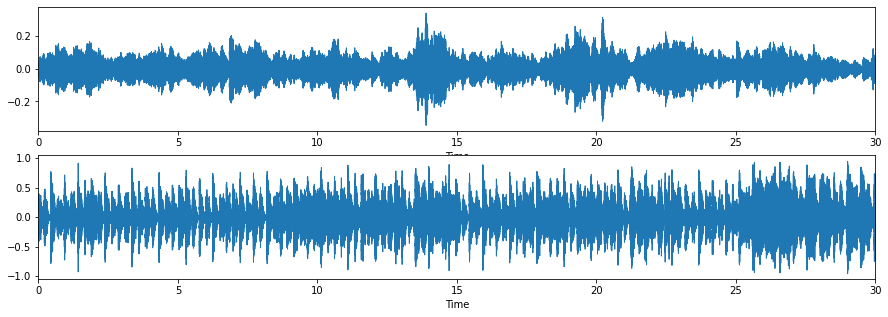

In [ ]:
fig, ax = plt.subplots(nrows= 2, ncols = 1, figsize = (15,5))
ld.waveplot(x1, sr = sr1, ax = ax[0])
ld.waveplot(x2, sr = sr2, ax = ax[1])
plt.show()

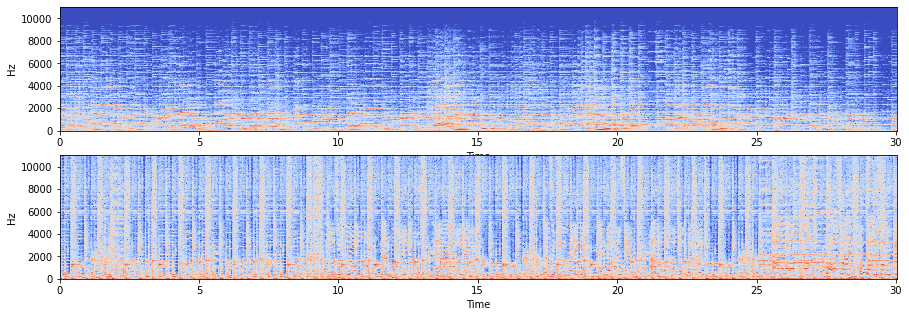

In [ ]:
x_spec1 = librosa.stft(x1)
x_spec_db1 = librosa.amplitude_to_db(abs(x_spec1))
x_spec2 = librosa.stft(x2)
x_spec_db2 = librosa.amplitude_to_db(abs(x_spec2))
fig, ax = plt.subplots(nrows= 2, ncols = 1, figsize = (15,5))
ld.specshow(x_spec_db1, sr = sr1, x_axis = "time", y_axis = "hz", ax = ax[0])
ld.specshow(x_spec_db2, sr = sr2, x_axis = "time", y_axis = "hz", ax = ax[1])
plt.show()

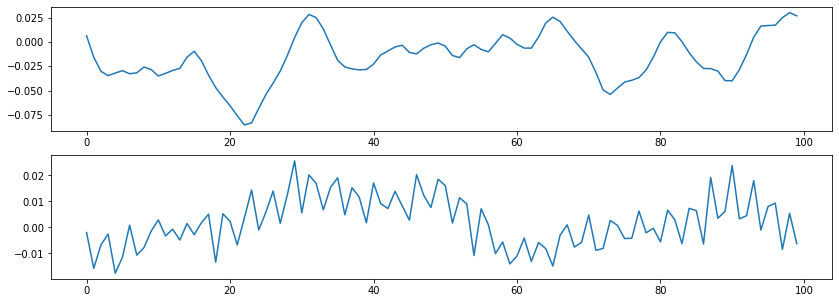

Zero Crossings for Classical: 11
Zero Crossings for Disco: 35


In [ ]:
n0 = 9000
n1 = 9100
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(14, 5))
ax[0].plot(x1[n0:n1])
ax[1].plot(x2[n0:n1])
plt.show()
print("Zero Crossings for Classical:", sum(librosa.zero_crossings(x1[n0:n1])))
print("Zero Crossings for Disco:", sum(librosa.zero_crossings(x2[n0:n1])))

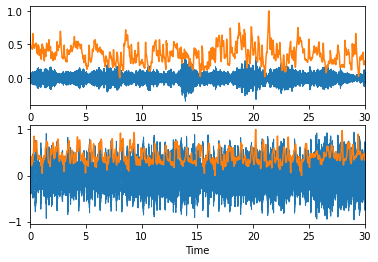

In [ ]:
spectral_centroids1 = librosa.feature.spectral_centroid(x1, sr = sr1)[0]
spectral_centroids2 = librosa.feature.spectral_centroid(x2, sr = sr2)[0]
frames1 = range(len(spectral_centroids1))
frames2 = range(len(spectral_centroids2))
t1 = librosa.frames_to_time(frames1)
t2 = librosa.frames_to_time(frames2)
def normalize(x, axis = 0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

fig, ax = plt.subplots(nrows = 2, ncols = 1)
librosa.display.waveplot(x1, sr1, ax = ax[0])
ax[0].plot(t1, normalize(spectral_centroids1))
librosa.display.waveplot(x2, sr2, ax = ax[1])
ax[1].plot(t2, normalize(spectral_centroids2))
plt.show()

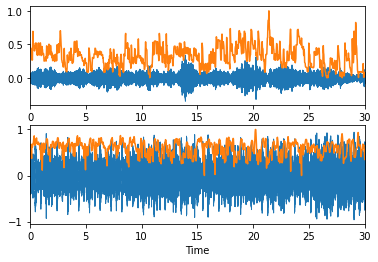

In [ ]:
spectral_rolloff1 = librosa.feature.spectral_rolloff(x1+0.01, sr1)[0]
spectral_rolloff2 = librosa.feature.spectral_rolloff(x2+0.01, sr2)[0]
fig, ax = plt.subplots(nrows = 2, ncols = 1)
librosa.display.waveplot(x1, sr1, ax = ax[0])
ax[0].plot(t1, normalize(spectral_rolloff1))
librosa.display.waveplot(x2, sr2, ax = ax[1])
ax[1].plot(t2, normalize(spectral_rolloff2))
plt.show()

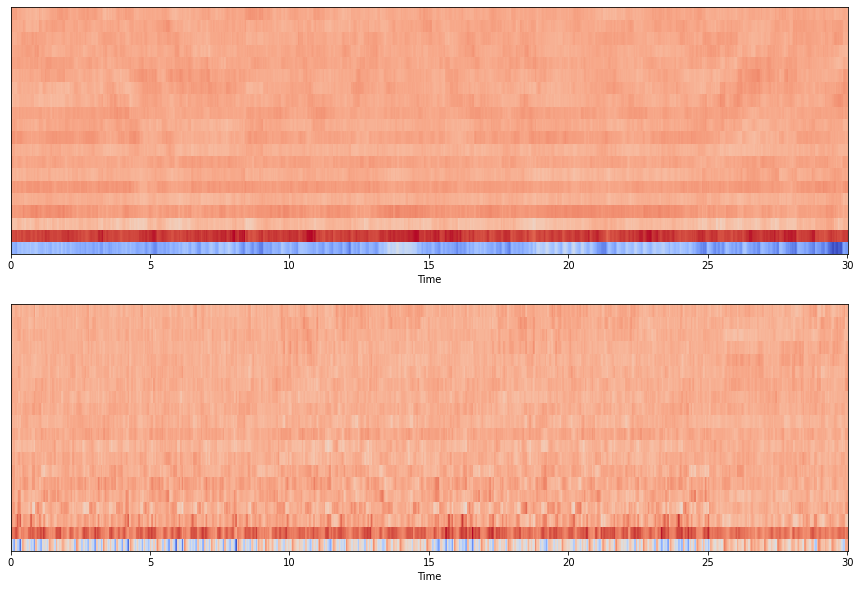

In [ ]:
mfcc1 = librosa.feature.mfcc(x1,sr1)
mfcc2 = librosa.feature.mfcc(x2,sr2)
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))
librosa.display.specshow(mfcc1,sr =  sr1, x_axis = "time", ax = ax[0])
librosa.display.specshow(mfcc2, sr = sr2, x_axis = "time", ax = ax[1])
plt.show()

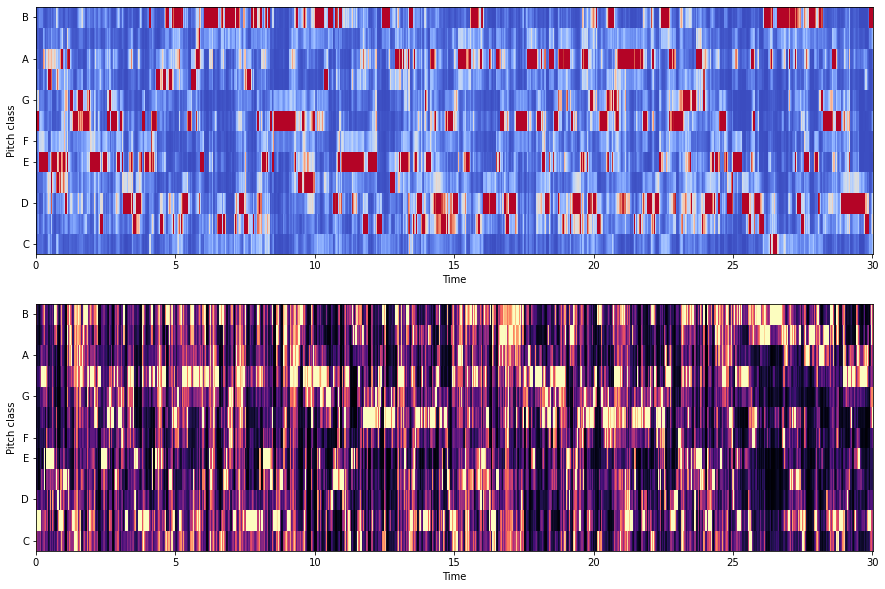

In [ ]:
chroma1 = librosa.feature.chroma_stft(x1, sr =sr1)
chroma2 = librosa.feature.chroma_stft(x2, sr = sr2)
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))
librosa.display.specshow(chroma1,sr =  sr1, x_axis = "time", y_axis = "chroma", ax = ax[0], cmap = "coolwarm")
librosa.display.specshow(chroma2, sr = sr2, x_axis = "time", y_axis = "chroma", ax = ax[1])
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from warnings import filterwarnings
import seaborn as sns
filterwarnings("ignore")

In [ ]:
data = {"chroma_stft_mean": [], "spectral_centroid_mean":[], "spectral_bandwidth_mean":[], "rms_mean":[], 
        "rolloff_mean": [], "zcr_mean": [], "label": []}
for i in range(1,21):
    data[f"mfcc{i}"] = []
for i in os.listdir("Data/genres_original"):
    for j in os.listdir(f"Data/genres_original/{i}"):
        try:
            x, sr = librosa.load(f"Data/genres_original/{i}/{j}")
            chroma = np.mean(librosa.feature.chroma_stft(x , sr = sr))
            data["chroma_stft_mean"].append(chroma)
            spec_cent = np.mean(librosa.feature.spectral_centroid(x, sr = sr))
            data["spectral_centroid_mean"].append(spec_cent)
            spec_bw = np.mean(librosa.feature.spectral_bandwidth(x, sr = sr))
            data["spectral_bandwidth_mean"].append(spec_bw)
            rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr = sr))
            data["rolloff_mean"].append(rolloff)
            rms = np.mean(librosa.feature.rms(x))
            data["rms_mean"].append(rms)
            zcr = np.mean(librosa.feature.zero_crossing_rate(x))
            data["zcr_mean"].append(zcr)
            data["label"].append(i)
            mfcc = librosa.feature.mfcc(x, sr = sr)
            for a in range(1,21):
                data[f"mfcc{a}"].append(np.mean(mfcc[a-1]))
        except:
            continue

In [ ]:
zcr = np.mean(librosa.feature.zero_crossing_rate(x))
data["zcr_mean"].append(zcr)
data["label"].append("a")
mfcc = librosa.feature.mfcc(x, sr = sr)
for a in range(1,21):
    data[f"mfcc{a}"].append(np.mean(mfcc[a-1]))

In [ ]:
df = pd.DataFrame(data)
df

chroma_stft_mean  spectral_centroid_mean  spectral_bandwidth_mean  \
0            0.414032             2938.155358              2839.657689   
1            0.429653             3191.197463              2948.001830   
2            0.297045             2308.673365              2618.607096   
3            0.421486             2807.798623              2778.260075   
4            0.384027             2797.844810              2847.551887   
..                ...                     ...                      ...   
994          0.331904             2218.663819              2306.830098   
995          0.440995             2417.757363              2431.888669   
996          0.440995             2417.757363              2431.888669   
997          0.414973             2825.891195              2680.155772   
998          0.416615             2481.466513              2178.434932   

     rms_mean  rolloff_mean  zcr_mean    label       mfcc1       mfcc2  \
0    0.230516   6279.551665  0.126988  country   -7.939366   62.723667   
1    0.236554   6926.704746  0.156873  country   12.180910   58.995853   
2    0.146586   5190.053453  0.074162  country -120.270332   79.230972   
3    0.214138   6022.583195  0.128308  country  -23.165638   71.154228   
4    0.248418   6221.176656  0.107205  country  -23.066956   70.261658   
..        ...           ...       ...      ...         ...         ...   
994  0.068239   4881.525522  0.096125    disco -182.073425  103.437645   
995  0.122678   5385.615642  0.112569    disco  -91.576141   99.457474   
996  0.122678   5385.615642  0.112569    disco  -91.576141   99.457474   
997  0.108184   6233.029621  0.120451    disco -116.921860   75.748466   
998  0.092015   4956.233913  0.134360    disco -133.819321   93.490356   

         mfcc3  ...     mfcc11     mfcc12     mfcc13    mfcc14     mfcc15  \
0    -1.456931  ...   0.312304   6.541569   0.736442 -1.773687   0.848610   
1     0.939475  ...  -2.196137   1.193048   0.483435  4.412107  -0.182598   
2     5.233848  ...  -6.351779   0.227432  -6.813057  1.617267  -1.786316   
3     1.578966  ...   2.916221   0.820290  -1.106009  0.111367  -3.348796   
4     3.813589  ...  -2.315719   2.089481  -3.375139  5.138017  -0.188453   
..         ...  ...        ...        ...        ...       ...        ...   
994 -18.197401  ... -14.328997  11.547935 -11.632956  5.600885  -8.047068   
995  -8.977487  ... -13.673561  15.638736 -15.456167  4.522359 -10.144856   
996  -8.977487  ... -13.673561  15.638736 -15.456167  4.522359 -10.144856   
997  -4.257497  ... -13.067987  13.410190 -13.231570  8.262755 -15.242319   
998 -24.230862  ...  -8.738843  11.976369  -5.324511  4.997527  -0.673590   

       mfcc16     mfcc17    mfcc18    mfcc19    mfcc20  
0    2.983559  -2.764677  2.824268 -1.738780  0.974067  
1    3.073260  -1.169091  4.573297  0.887555  1.296123  
2   -0.700590  -4.772855 -0.286400 -5.357112 -1.965473  
3    0.188658  -1.208899 -1.514774 -2.725631 -2.110019  
4    0.375013   0.615662  4.062637  0.909476  4.095611  
..        ...        ...       ...       ...       ...  
994  0.270297  -8.090955  2.725034 -3.292579  3.513175  
995  0.477925 -10.156887  4.787725 -6.897259 -0.993489  
996  0.477925 -10.156887  4.787725 -6.897259 -0.993489  
997  9.851818  -6.221204  8.014792 -8.036930  4.391324  
998  3.728633   2.098823  5.433709  3.084095  2.458709  

[999 rows x 27 columns]

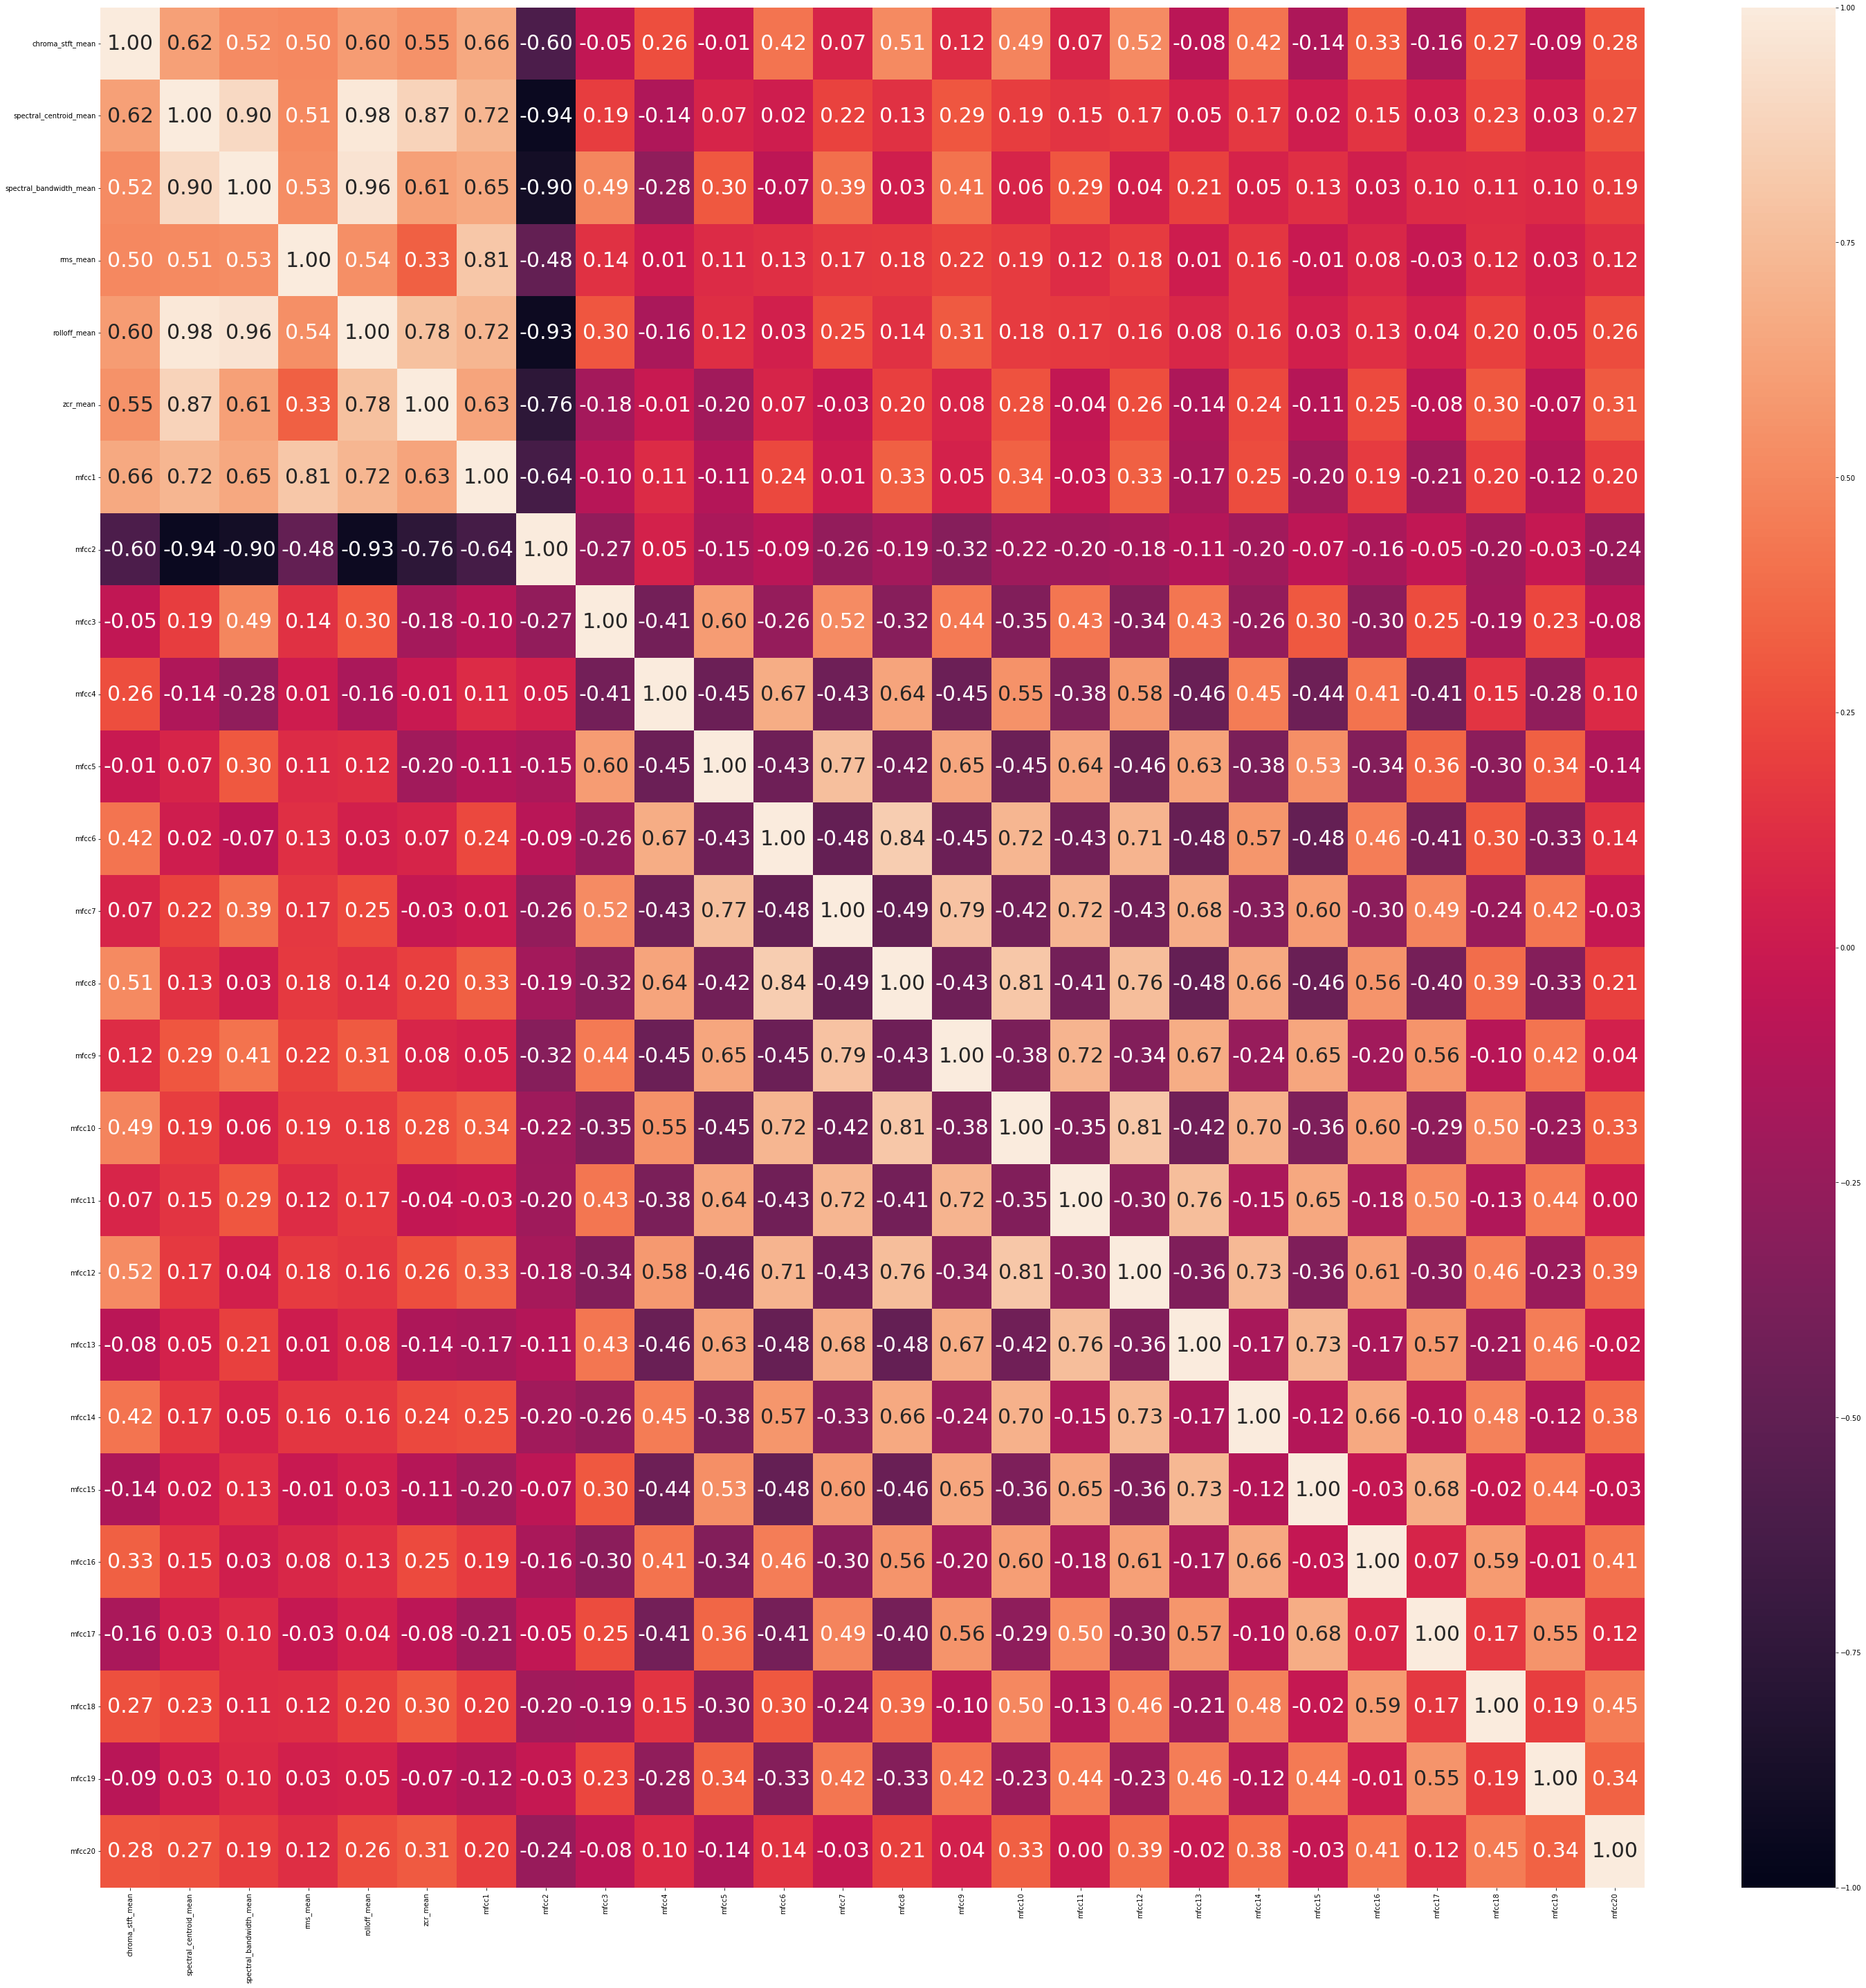

In [ ]:
plt.figure(figsize = (50,50))
sns.heatmap(df.corr(), annot = True, annot_kws = {"Size": 30}, fmt =".2f", vmin = -1, vmax = 1)
plt.show()

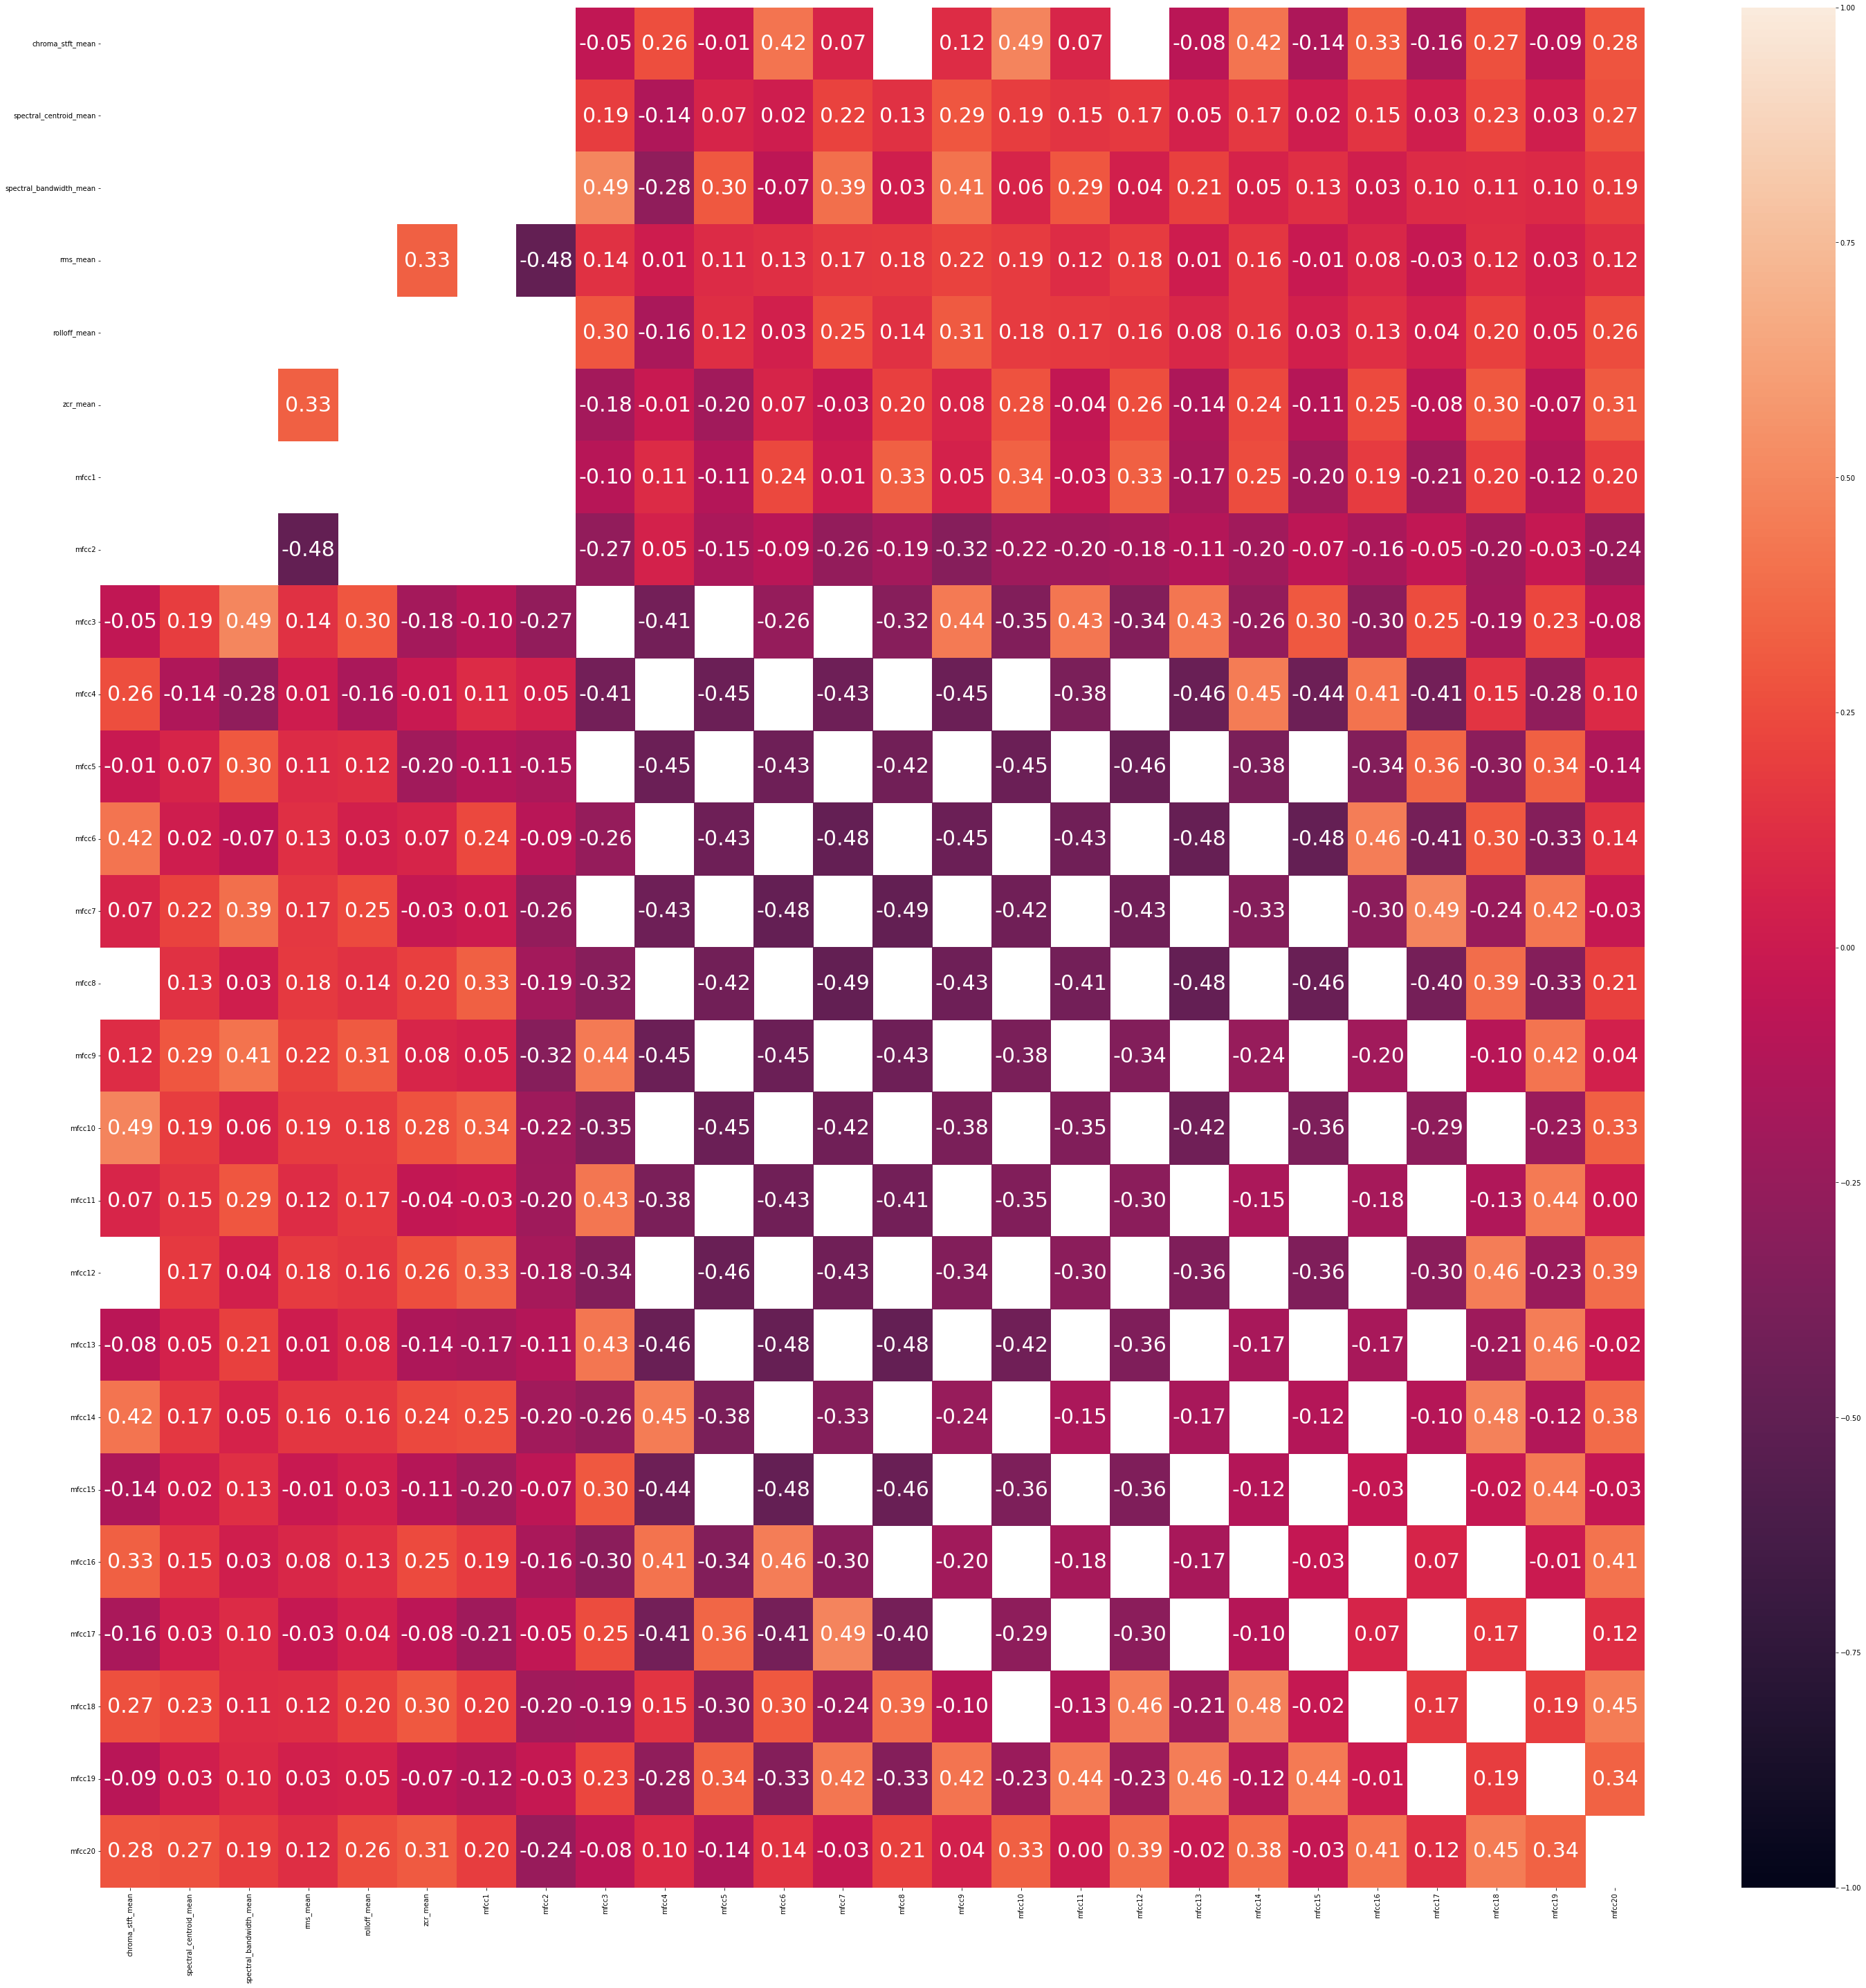

In [ ]:
plt.figure(figsize = (50,50))
sns.heatmap(df.corr()[(df.corr()<0.5) & (df.corr()>-0.5)], annot = True, annot_kws = {"Size": 30}, fmt =".2f", vmin = -1, vmax = 1)
plt.show()

In [ ]:
scaler = MinMaxScaler()
new_df = scaler.fit_transform(df.drop(["label"], axis = 1))
new_df.shape

(999, 26)

In [ ]:
new_label = pd.get_dummies(data["label"])
new_label

blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  rock
0        0          0        1      0       0     0      0    0       0     0
1        0          0        1      0       0     0      0    0       0     0
2        0          0        1      0       0     0      0    0       0     0
3        0          0        1      0       0     0      0    0       0     0
4        0          0        1      0       0     0      0    0       0     0
..     ...        ...      ...    ...     ...   ...    ...  ...     ...   ...
994      0          0        0      1       0     0      0    0       0     0
995      0          0        0      1       0     0      0    0       0     0
996      0          0        0      1       0     0      0    0       0     0
997      0          0        0      1       0     0      0    0       0     0
998      0          0        0      1       0     0      0    0       0     0

[999 rows x 10 columns]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_df, new_label, test_size= 0.2, stratify= new_label)

In [ ]:
model = Sequential()
model.add(Dense(units = 256, activation = "relu", input_shape = (26,), kernel_initializer = "uniform"))
model.add(Dense(units = 256, activation = "relu", kernel_initializer = "uniform"))
model.add(Dense(units = 128, activation = "relu", kernel_initializer = "uniform"))
model.add(Dense(units = 128, activation = "relu", kernel_initializer = "uniform"))
model.add(Dense(units = 10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 9
epochs = 200
H = model.fit(x_train ,y_train , batch_size = batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/200
71/71 [==============================] - 1s 5ms/step - loss: 2.2778 - accuracy: 0.1518 - val_loss: 2.1858 - val_accuracy: 0.2250
Epoch 2/200
71/71 [==============================] - 0s 3ms/step - loss: 1.9732 - accuracy: 0.2848 - val_loss: 1.8469 - val_accuracy: 0.3250
Epoch 3/200
71/71 [==============================] - 0s 3ms/step - loss: 1.7828 - accuracy: 0.3099 - val_loss: 1.8128 - val_accuracy: 0.3063
Epoch 4/200
71/71 [==============================] - 0s 3ms/step - loss: 1.7184 - accuracy: 0.3521 - val_loss: 1.7101 - val_accuracy: 0.3625
Epoch 5/200
71/71 [==============================] - 0s 3ms/step - loss: 1.6175 - accuracy: 0.3662 - val_loss: 1.5816 - val_accuracy: 0.3938
Epoch 6/200
71/71 [==============================] - 0s 3ms/step - loss: 1.5843 - accuracy: 0.3897 - val_loss: 1.5681 - val_accuracy: 0.4375
Epoch 7/200
71/71 [==============================] - 0s 3ms/step - loss: 1.5700 - accuracy: 0.4210 - val_loss: 1.5495 - val_accuracy: 0.3500
Epoch 8/200
7

In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = []
y_test_new = []
for i in y_pred_prob:
    y_pred.append(np.argmax(i))
for i in y_test.values:
    y_test_new.append(np.argmax(i))

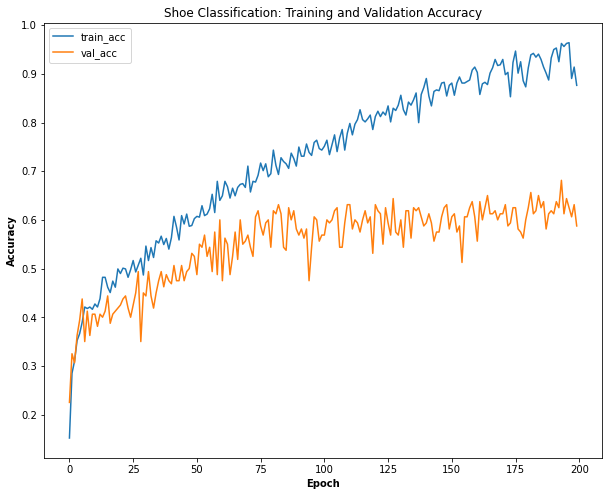

In [ ]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Shoe Classification: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

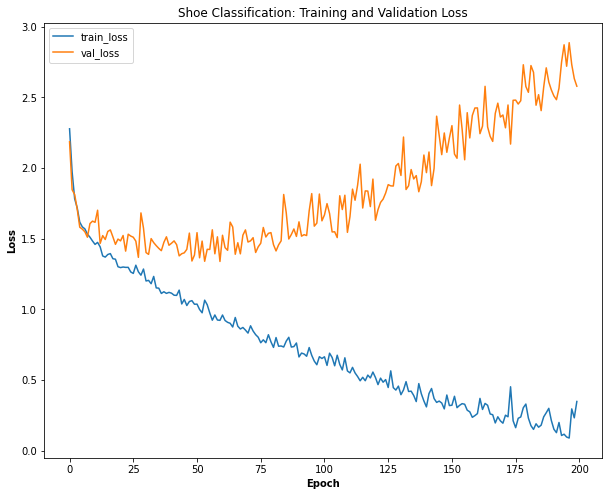

In [ ]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Shoe Classification: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [ ]:
def model_evaluation(y_test, y_pred):
    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred), "\n")
    print("Classification Report--> \n", classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot =True, fmt ="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

Cohen Kappa Score: 0.5111111111111111 

Classification Report--> 
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.89      0.85      0.87        20
           2       0.50      0.60      0.55        20
           3       0.45      0.25      0.32        20
           4       0.41      0.60      0.49        20
           5       0.63      0.60      0.62        20
           6       0.60      0.60      0.60        20
           7       0.82      0.90      0.86        20
           8       0.50      0.55      0.52        20
           9       0.21      0.15      0.18        20

    accuracy                           0.56       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.55      0.56      0.55       200



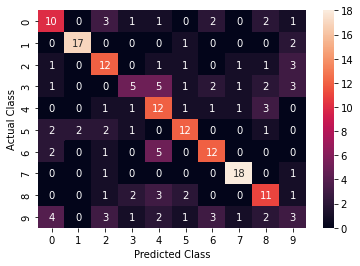

In [ ]:
model_evaluation(y_test_new, y_pred)